In [5]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score


In [7]:
# load data
df = pd.read_csv("loan.csv")

display(df.head())

print(df.shape)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500,36 months,13.56,84.92,C,C1,Chef,10+ years,RENT,55000.0,Not Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,109xx,NY,18.24,0,Apr-2001,1,NaN,45.0,9,1,4341,10.3,34,w,2386.02,2386.02,167.02,167.02,113.98,53.04,0.0,0.0,0.0,Feb-2019,84.92,Mar-2019,Feb-2019,0,NaN,1,Individual,NaN,NaN,NaN,0,0,16901,2,2,1,2,2.0,12560,69.0,2,7,2137,28.0,42000,1,11,2,9,1878.0,34360.0,5.9,0,0,140.0,212,1,1,0,1.0,NaN,2.0,NaN,0,2,5,3,3,16,7,18,5,9,0.0,0,0,3,100.0,0.0,1,0,60124,16901,36500,18124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000,60 months,18.94,777.23,D,D2,Postmaster,10+ years,MORTGAGE,90000.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,713xx,LA,26.52,0,Jun-1987,0,71.0,75.0,13,1,12315,24.2,44,w,29387.75,29387.75,1507.11,1507.11,612.25,894.86,0.0,0.0,0.0,Feb-2019,777.23,Mar-2019,Feb-2019,0,NaN,1,Individual,NaN,NaN,NaN,0,1208,321915,4,4,2,3,3.0,87153,88.0,4,5,998,57.0,50800,2,15,2,10,24763.0,13761.0,8.3,0,0,163.0,378,4,3,3,4.0,NaN,4.0,NaN,0,2,4,4,9,27,8,14,4,13,0.0,0,0,6,95.0,0.0,1,0,372872,99468,15000,94072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000,36 months,17.97,180.69,D,D1,Administrative,6 years,MORTGAGE,59280.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,490xx,MI,10.51,0,Apr-2011,0,NaN,NaN,8,0,4599,19.1,13,w,4787.21,4787.21,353.89,353.89,212.79,141.10,0.0,0.0,0.0,Feb-2019,180.69,Mar-2019,Feb-2019,0,NaN,1,Individual,NaN,NaN,NaN,0,0,1102

(23994, 145)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171346 entries, 0 to 171345
Columns: 145 entries, id to settlement_term
dtypes: float64(108), int64(2), object(35)
memory usage: 189.6+ MB


In [8]:
# Drop unnecessary columns
drop_cols = ['id', 'member_id','url', 'desc','title','emp_title']
df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)


# Dropping columns with > 40% missing values
missing_threshold = 0.4
missing_cols = df.columns[df.isnull().mean() > missing_threshold]
df.drop(columns=missing_cols, inplace=True)

In [9]:
df.shape

(23994, 100)

In [10]:
# Handling missing values

for col in df.select_dtypes(include=['int64','float64']).columns:
    df[col].fillna(df[col].median(), inplace=True)

for col in df.select_dtypes(include='object').columns:
    df[col].fillna('Unknown', inplace=True)

In [11]:
df.isnull().sum()

,0
loan_amnt,0
funded_amnt,0
funded_amnt_inv,0
term,0
int_rate,0
installment,0
grade,0
sub_grade,0
emp_length,0
home_ownership,0


In [12]:
# 3 ENcoding categorical variables
df.shape

(23994, 100)

In [13]:
# inspecting object columns
obj_cols = df.select_dtypes(include='object').columns
df[obj_cols].nunique().sort_values(ascending=False)

,0
zip_code,845
earliest_cr_line,569
addr_state,50
sub_grade,31
emp_length,12
purpose,12
grade,7
loan_status,6
last_credit_pull_d,5
last_pymnt_d,4


In [14]:
# extracting features based on cardinality

df.drop(columns=['zip_code', 'pymnt_plan'], inplace=True, errors='ignore')

# date time columns
date_cols = ['issue_d', 'last_pymnt_d', 'last_credit_pull_d', 'next_pymnt_d', 'earliest_cr_line']
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Extract useful features from issue_d
if 'issue_d' in df.columns:
    df['issue_year'] = df['issue_d'].dt.year
    df['issue_month'] = df['issue_d'].dt.month
    df.drop(columns=['issue_d'], inplace=True)

# Extract credit age in years from earliest_cr_line
if 'earliest_cr_line' in df.columns:
    df['credit_age_years'] = (pd.to_datetime('today') - df['earliest_cr_line']).dt.days // 365
    df.drop(columns=['earliest_cr_line'], inplace=True)


# ==== 3. Map emp_length to numeric values ====
emp_length_map = {
    '10+ years': 10, '9 years': 9, '8 years': 8, '7 years': 7,
    '6 years': 6, '5 years': 5, '4 years': 4, '3 years': 3,
    '2 years': 2, '1 year': 1, '< 1 year': 0, 'n/a': 0
}
if 'emp_length' in df.columns:
    df['emp_length'] = df['emp_length'].map(emp_length_map)

# ==== 4. Label Encode ordinal or high-cardinality object column: sub_grade ====
if 'sub_grade' in df.columns:
    le = LabelEncoder()
    df['sub_grade'] = le.fit_transform(df['sub_grade'].astype(str))

# ==== 5. One-hot encode low-cardinality categorical columns ====
low_card_cols = [
    'addr_state', 'purpose', 'grade', 'home_ownership',
    'verification_status', 'term', 'application_type',
    'initial_list_status', 'disbursement_method',
    'hardship_flag', 'debt_settlement_flag'
]

# Keep only columns that still exist in the DataFrame
low_card_cols = [col for col in low_card_cols if col in df.columns]
df = pd.get_dummies(df, columns=low_card_cols, drop_first=True)

# ==== 6. Convert loan_status to binary classification target ====
if 'loan_status' in df.columns:
  # Map any "bad" status to 1 (default), all else to 0
  bad_statuses = ['Charged Off', 'Default', 'Late (31-120 days)', 'Late (16-30 days', 'In Grace Period']
  df['loan_status'] = df['loan_status'].apply(lambda x: 1 if x in bad_statuses else 0)



print("✅ Object columns processed. DataFrame shape:", df.shape)


✅ Object columns processed. DataFrame shape: (23994, 163)


# Train Classification Models

In [15]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

datetime_cols = X_train.select_dtypes(include='datetime64').columns

# Extract year and month from datetime columns
for col in datetime_cols:
    X_train[f'{col}_year'] = X_train[col].dt.year
    X_train[f'{col}_month'] = X_train[col].dt.month
    X_test[f'{col}_year'] = X_test[col].dt.year
    X_test[f'{col}_month'] = X_test[col].dt.month

# Drop original datetime columns
X_train.drop(columns=datetime_cols, inplace=True)
X_test.drop(columns=datetime_cols, inplace=True)

# ===== Impute missing values =====
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_train.median())

# Balance training data using SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print(f"✅ SMOTE applied.\nResampled training set shape: {X_train_res.shape}")
print("Class distribution after resampling:\n", y_train_res.value_counts())


✅ SMOTE applied.
Resampled training set shape: (38186, 165)
Class distribution after resampling:
 loan_status
0    19093
1    19093
Name: count, dtype: int64


In [16]:
# traning & evaluating LightGBM
# 1. Train LightGBM on the balanced training data
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)

# 2. Predict on the original (unbalanced) test set
y_pred = lgb_model.predict(X_test)
y_proba = lgb_model.predict_proba(X_test)[:, 1]  # Probability for positive class

# 3. Evaluation metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 102, number of negative: 19093
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9616
[LightGBM] [Info] Number of data points in the train set: 19195, number of used features: 150
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005314 -> initscore=-5.232104
[LightGBM] [Info] Start training from score -5.232104
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      4773
           1       0.26      0.46      0.33        26

    accuracy                           0.99      4799
   macro avg       0.63      0.73      0.66      4799
weighted avg       0.99      0.99      0.99      4799

Confusion Ma

In [21]:
# LightGBM Metrics
from sklearn.svm import SVC

# Use same X_train and y_train from earlier
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

lgbm_precision = precision_score(y_test, y_pred)
lgbm_recall = recall_score(y_test, y_pred)
lgbm_f1 = f1_score(y_test, y_pred)
lgbm_auc = roc_auc_score(y_test, y_pred)

# SVM Metrics
svm_precision = precision_score(y_test, y_pred_svm)
svm_recall = recall_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm)
svm_auc = roc_auc_score(y_test, y_pred_svm)
# 📊 Print Results
print("✅ LightGBM Performance:")
print(f"Precision: {lgbm_precision:.4f}")
print(f"Recall:    {lgbm_recall:.4f}")
print(f"F1 Score:  {lgbm_f1:.4f}")
print(f"ROC AUC:   {lgbm_auc:.4f}")

print("\n✅ SVM Performance:")
print(f"Precision: {svm_precision:.4f}")
print(f"Recall:    {svm_recall:.4f}")
print(f"F1 Score:  {svm_f1:.4f}")
print(f"ROC AUC:   {svm_auc:.4f}")



✅ LightGBM Performance:
Precision: 0.2609
Recall:    0.4615
F1 Score:  0.3333
ROC AUC:   0.7272

✅ SVM Performance:
Precision: 0.0000
Recall:    0.0000
F1 Score:  0.0000
ROC AUC:   0.5000


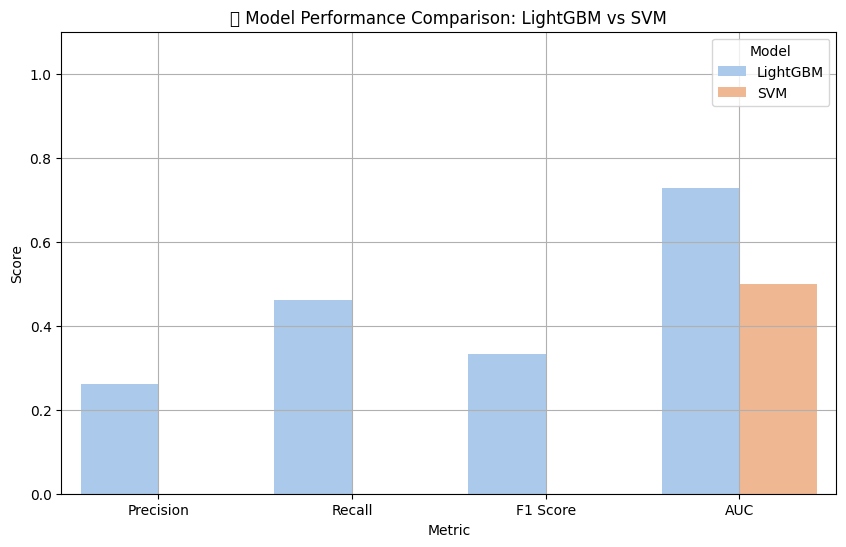

In [20]:
# Combine results
comparison_df = pd.DataFrame({
    'Model': ['LightGBM', 'SVM'],
    'Precision': [lgbm_precision, svm_precision],
    'Recall': [lgbm_recall, svm_recall],
    'F1 Score': [lgbm_f1, svm_f1],
    'AUC': [lgbm_auc, svm_auc]
})

# Reshape for bar plot
comparison_melted = comparison_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=comparison_melted, x='Metric', y='Score', hue='Model', palette='pastel')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('📊 Model Performance Comparison: LightGBM vs SVM')
plt.ylim(0, 1.1)
plt.grid(True)
plt.show()


# ***Conclusion & Recommendation:***
**LightGBM clearly outperformed SVM in this task. While there is still room for improvement (especially in recall), LightGBM is currently the more reliable model for predicting loan default. Further improvements could include hyperparameter tuning, feature selection, and advanced ensemble techniques.**